# Chapter-5 Model Quantization using ONNX Runtime

#### In this notebook, we will try to quantize BERT model which is trained on Squad2.0 dataset. We will be using ONNX Runtime for this. We will try to quantize using static quantization (Post Training Quantization), dynamic quantization and Quantization Aware Training.

### Step-1 Export model and measure original model's accuracy

In [1]:
# Install prerequisites
!pip install onnx==1.18.0 onnxruntime==1.22.0 onnx-simplifier==0.4.36
!pip install transformers==4.53.2 datasets==4.0.0 evaluate==0.4.5
!pip install netron==8.4.3 seaborn==0.13.2 tqdm==4.67.1
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 \
    --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-linux_x86_64.whl.metadata (26 kB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-linux_x86_64.whl (178.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.1+cu124
    Uninstalling torchvision-0.19.1+cu124:
      Successfully uninstalled torchvision-0.19.1+cu124


In [2]:
# Import all the dependencies

import os
import onnx
import time
import torch
import random
import evaluate
import numpy as np
from tqdm import tqdm
import seaborn as sns
import onnxruntime as ort
from datasets import Dataset
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import defaultdict
from torch.utils.data import DataLoader
from datasets import concatenate_datasets
from torch.nn.utils.rnn import pad_sequence
from onnxruntime.quantization.shape_inference import quant_pre_process
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from onnxruntime.quantization import quantize_static, quantize_dynamic, CalibrationDataReader, QuantType

In [3]:
# Load IMDb test dataset
dataset = load_dataset("imdb")
test_dataset = dataset["test"]

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("fabriceyhc/bert-base-uncased-imdb")
model = AutoModelForSequenceClassification.from_pretrained("fabriceyhc/bert-base-uncased-imdb")

# Export model to onnx
dummy_inputs = tokenizer(test_dataset[0]["text"], return_tensors="pt")
onnx_model_path = "./bert_base_uncased_imdb.onnx"

torch.onnx.export(model, (dummy_inputs["input_ids"], dummy_inputs["attention_mask"]),
                  onnx_model_path,
                  input_names=["input_ids", "attention_mask"], output_names=["logits"],
                  dynamic_axes={"input_ids": {0: "batch_size", 1: "sequence"},
                                "attention_mask": {0: "batch_size", 1: "sequence"},
                                "logits": {0: "batch_size"}}
                 )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


In [4]:
def get_test_dataset():
    dataset = load_dataset("imdb")
    test_dataset = dataset["test"]

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)

    # Tokenize test dataset
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    tokenized_test = tokenized_test.remove_columns(["text"])
    tokenized_test = tokenized_test.rename_column("label", "labels")
    tokenized_test.set_format("torch")

    return tokenized_test

In [5]:
def sample_subset(sample_dataset, start_index, end_index, num_samples=500):
    # Generate random indices within the range
    random_indices = random.sample(range(start_index, end_index + 1), num_samples)

    # Extract randomly sampled data
    subset_data = [sample_dataset[i] for i in random_indices]

    # Convert the sampled data into a Hugging Face Dataset
    subset_dataset = Dataset.from_list(subset_data)
    return subset_dataset

def get_calibration_dataset():
    # Load test dataset
    test_dataset = get_test_dataset()

    # Randomly sample 500 sequences from first 12500 samples and do the same from
    # other 12500 samples. First 12500 are negative labeled samples and rest are
    # positive labeled samples.
    negative_subset = sample_subset(test_dataset, 0, 12499, 500)
    positive_subset = sample_subset(test_dataset, 12500, 24999, 500)

    # Merge the two subsets
    merged_dataset = concatenate_datasets([negative_subset, positive_subset])
    merged_dataset.set_format("torch")

    return merged_dataset

In [6]:
def get_dataloader(dataset_instance, batch_size=1, num_workers=0):
    # Define collate function to combine sequences of different lengths.
    def collate_batch(sample):
        updated_sample = defaultdict(list)
        for batch in sample:
            for k, v in batch.items():
                if k == "labels":
                    v = v.unsqueeze(dim=0)
                updated_sample[k].append(v)

        for k, v in updated_sample.items():
            updated_sample[k] = pad_sequence(v, batch_first=True)
        return updated_sample

    # Create a DataLoader for batching
    dataloader = DataLoader(
        dataset_instance,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_batch
    )

    return dataloader

In [7]:
def plot_histogram(sample_dataset):
    label_1_lengths = []
    label_0_lengths = []

    for data in sample_dataset:
        if data["labels"] == 1:
            label_1_lengths.append(len(data["input_ids"]))
        else:
            label_0_lengths.append(len(data["input_ids"]))

    # Plot histogram for label 0 (negative reviews)
    plt.hist(label_0_lengths, bins=50, alpha=0.5, color='blue', label="Label 0 (Negative)", density=True)

    # Plot histogram for label 1 (positive reviews)
    plt.hist(label_1_lengths, bins=50, alpha=0.5, color='red', label="Label 1 (Positive)", density=True)

    plt.xlabel("Sequence Length (Number of tokens)")
    plt.ylabel("Density")
    plt.title("Histogram of IMDb Review Lengths by Label")
    plt.legend()
    plt.grid()
    plt.show()

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

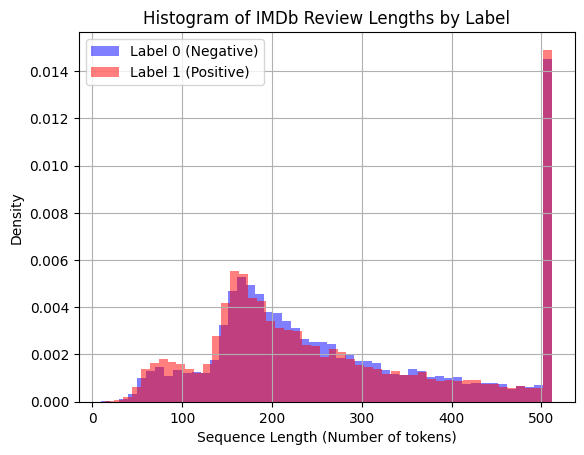

In [8]:
test_dataset = get_test_dataset()
plot_histogram(test_dataset)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

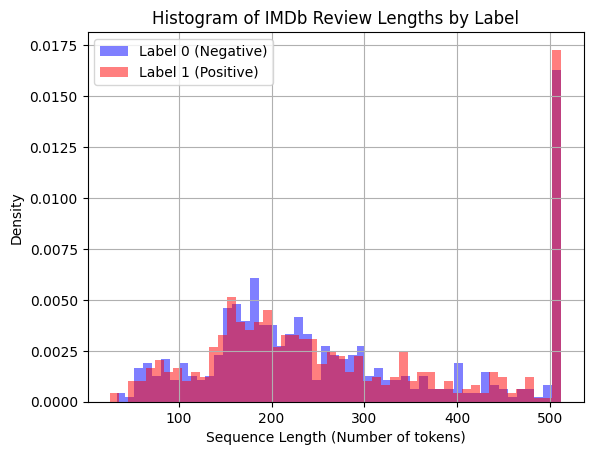

In [9]:
calibration_dataset = get_calibration_dataset()
plot_histogram(calibration_dataset)

In [10]:
def compute_accuracy(onnx_model_path, tokenizer):
    # Define evaluation metric
    metric = evaluate.load("accuracy")

    # Prepare calibration dataloader
    calibration_dataloader = get_dataloader(calibration_dataset)

    # Load onnx model
    sess_option = ort.SessionOptions()
    sess = ort.InferenceSession(onnx_model_path, sess_option, providers=['CPUExecutionProvider'])

    # Batch inference
    all_predictions = []
    all_labels = []
    for batch in tqdm(calibration_dataloader):
        inputs = {key: batch[key].numpy() for key in ["input_ids", "attention_mask"]}
        labels = batch["labels"]

        outputs = sess.run(None, inputs)
        logits = outputs[0]
        predictions = np.argmax(logits, axis=-1)

        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Compute accuracy
    accuracy = metric.compute(predictions=np.array(all_predictions), references=np.array(all_labels))
    return accuracy

def compute_speed(onnx_model_path, num_iter=10):
    # Load onnx model
    sess_option = ort.SessionOptions()
    sess = ort.InferenceSession(onnx_model_path, sess_option, providers=['CPUExecutionProvider'])

    # Batch inference of [16, 512] fixed shaped input.
    dummy_inputs = {"input_ids" : np.random.randint(0, 100, size=(16, 512)), "attention_mask" : np.ones(shape=(16, 512), dtype=np.int64)}
    start = time.time()
    for i in tqdm(range(num_iter)):
        outputs = sess.run(None, dummy_inputs)
    end = time.time()

    return (end - start) / num_iter

In [11]:
# Compute accuracy
accuracy_orig = compute_accuracy(onnx_model_path, tokenizer)
print(f"\nOriginal model Test Accuracy: {accuracy_orig['accuracy']:.4f}")

# Compute inference speed
speed_orig = compute_speed(onnx_model_path)
print(f"\nOriginal model Inference Speed: {speed_orig:.4f} seconds")

100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s]



Original model Test Accuracy: 0.9220


100%|██████████| 10/10 [04:32<00:00, 27.20s/it]


Original model Inference Speed: 27.2046 seconds


### Step-2 Static Quantization of model

In [12]:
onnx_model_path_static_quant = "./bert_base_uncased_imdb_static_quantized.onnx"

# Custom data reader for calibration
class BertDataReader(CalibrationDataReader):
    def __init__(self):
        self.data = get_dataloader(calibration_dataset)
        self.enum_data = iter(self.data)

    def get_next(self):
        data = next(self.enum_data, None)
        if data is None:
            return None

        data.pop("token_type_ids")
        data.pop("labels")

        for k, v in data.items():
            data[k] = v.numpy()
        return data

    def rewind(self):
        self.enum_data = iter(self.data)


# Firstly, apply shape inference and onnxruntime model optimization before quantizing the model.
quant_pre_process(onnx_model_path, onnx_model_path_static_quant, skip_symbolic_shape=True)

# Apply static quantization
quantize_static(
    model_input=onnx_model_path_static_quant,            # Input ONNX model
    model_output=onnx_model_path_static_quant,           # Output quantized model
    calibration_data_reader=BertDataReader(),
    weight_type=QuantType.QInt8,        # Quantize weights to int8
    activation_type=QuantType.QInt8,    # Quantize activations to int8
    calibration_providers=["CPUExecutionProvider"],
)

print(f"Quantized model saved at: {onnx_model_path_static_quant}")

# Compare model sizes
fp32_size = os.path.getsize(onnx_model_path) / 1024 / 1024
quant_size = os.path.getsize(onnx_model_path_static_quant) / 1024 / 1024

print(f"FP32 Model Size: {fp32_size:.2f} MB")
print(f"Quantized Model Size: {quant_size:.2f} MB")

Quantized model saved at: ./bert_base_uncased_imdb_static_quantized.onnx
FP32 Model Size: 417.90 MB
Quantized Model Size: 105.12 MB


In [13]:
# Compute accuracy
accuracy_static_quant = compute_accuracy(onnx_model_path_static_quant, tokenizer)
print(f"\nStatic Quantized model Test Accuracy: {accuracy_static_quant['accuracy']:.4f}")

# Compute inference speed
speed_static_quant = compute_speed(onnx_model_path_static_quant)
print(f"\nStatic Quantized model Inference Speed: {speed_static_quant:.4f} seconds")

100%|██████████| 1000/1000 [16:33<00:00,  1.01it/s]



Static Quantized model Test Accuracy: 0.7810


100%|██████████| 10/10 [05:36<00:00, 33.64s/it]


Static Quantized model Inference Speed: 33.6381 seconds


### Step-3 Dynamic Quantization of model

In [14]:
onnx_model_path_dynamic_quant = "./bert_base_uncased_imdb_dynamic_quantized.onnx"

# Firstly, apply shape inference and onnxruntime model optimization before quantizing the model.
quant_pre_process(onnx_model_path, onnx_model_path_dynamic_quant, skip_symbolic_shape=True)

# Apply dynamic quantization
quantized_model = quantize_dynamic(
    model_input=onnx_model_path_dynamic_quant,        # Input ONNX model
    model_output=onnx_model_path_dynamic_quant,       # Output quantized model
    weight_type=QuantType.QInt8     # Quantize only weights to int8, activations will be quantize during runtime
)

print(f"Quantized model saved at: {onnx_model_path_dynamic_quant}")

# Compare model sizes
fp32_size = os.path.getsize(onnx_model_path) / 1024 / 1024
quant_size = os.path.getsize(onnx_model_path_dynamic_quant) / 1024 / 1024

print(f"FP32 Model Size: {fp32_size:.2f} MB")
print(f"Quantized Model Size: {quant_size:.2f} MB")

Quantized model saved at: ./bert_base_uncased_imdb_dynamic_quantized.onnx
FP32 Model Size: 417.90 MB
Quantized Model Size: 105.06 MB


In [15]:
# Compute accuracy
accuracy_dynamic_quant = compute_accuracy(onnx_model_path_dynamic_quant, tokenizer)
print(f"\nDynamic Quantized model Test Accuracy: {accuracy_dynamic_quant['accuracy']:.4f}")

# Compute inference speed
speed_dynamic_quant = compute_speed(onnx_model_path_dynamic_quant)
print(f"\nDynamic Quantized model Inference Speed: {speed_dynamic_quant:.4f} seconds")

100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]



Dynamic Quantized model Test Accuracy: 0.9230


100%|██████████| 10/10 [03:23<00:00, 20.33s/it]


Dynamic Quantized model Inference Speed: 20.3278 seconds


### Step-4 Compare the models

In [16]:
# Helper function to plot the bar chart
def plot_chart(values, labels, title, y_label):
    # Set a modern style
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))

    # Create bar chart
    colors = sns.color_palette("Blues", n_colors=len(values))  # Soft color theme
    bars = plt.bar(labels, values, color=colors, edgecolor="black", linewidth=1.2)

    # Add labels on top of bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f"{bar.get_height():.2f}", ha='center', fontsize=12, fontweight='bold')

    # Aesthetic improvements
    plt.title(title, fontsize=14, fontweight='bold', color='#333')
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylim(0, max(values) * 1.2)  # Add some space at the top

    # Remove unnecessary borders
    sns.despine()

    # Show plot
    plt.show()

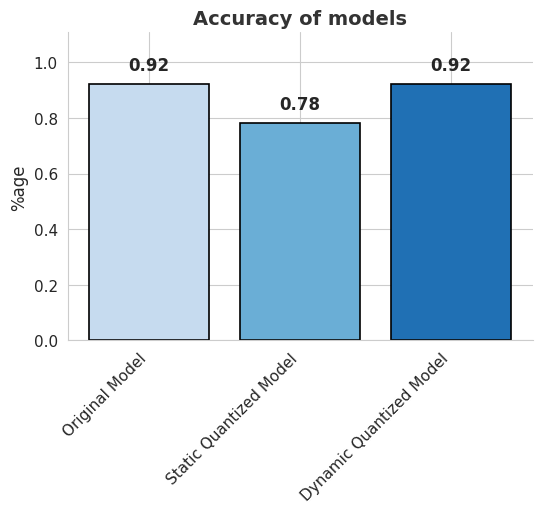

In [17]:
# Plot accuracy
labels = ["Original Model", "Static Quantized Model", "Dynamic Quantized Model"]
values = [accuracy_orig['accuracy'], accuracy_static_quant['accuracy'], accuracy_dynamic_quant['accuracy']]
plot_chart(values, labels, "Accuracy of models", "%age")

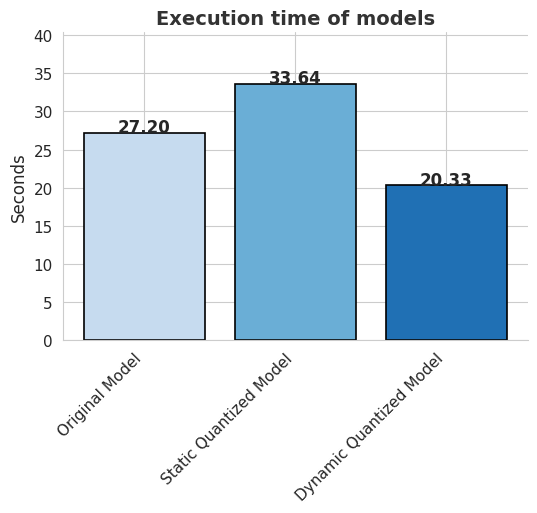

In [18]:
# Plot Execution time
labels = ["Original Model", "Static Quantized Model", "Dynamic Quantized Model"]
values = [speed_orig, speed_static_quant, speed_dynamic_quant]
plot_chart(values, labels, "Execution time of models", "Seconds")